<a href="https://colab.research.google.com/github/aitorfacio/06_MIAR_Aprendizaje_No_Supervisado/blob/main/DCGAN_FashionMNIST_Pra%CC%81ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este ejemplo vamos a tratar de generar imágenes similares a las del dataset de ropa FashionMNIST.

Pero esta vez lo váis a hacer vosotros :)

In [1]:
# importamos las librerías necesarias
import numpy as np
# buscad el dataset Fashion MNIST disponible en Keras e importadlo
# https://keras.io/datasets/
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import matplotlib.pyplot as plt

In [2]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # AQUÍ VUESTRO CÓDIGO
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [3]:
# definimos el generador
def define_generator(latent_dim):
    model = Sequential()
    # fully connected
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # convolución inversa genera la primera imagen
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # convolución inversa para escalar la imagen anterior
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='sigmoid'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    # AQUÍ VUESTRO CÓDIGO

    return model

In [4]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # Recordad: congeláis el discriminador
    #for layer in d_model.layers:
    #   layer.trainable = False

    d_model.trainable = False

    # AQUÍ VUESTRO CÓDIGO

    # creáis el modelo y conectáis el G(z) al D(x)
    model = Sequential()


    # AQUÍ VUESTRO CÓDIGO

    # añadimos el generador primero: él es el encargado de generar una muestra
    # a partir del espacio latente
    model.add(g_model)

    # AQUÍ VUESTRO CÓDIGO

    # y el discriminador después: le introducimos la muestra generada por el
    # G(z) para que nos diga si cree que es real o fake
    model.add(d_model)

    # AQUÍ VUESTRO CÓDIGO

    # y compiláis el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    # AQUÍ VUESTRO CÓDIGO

    return model

In [5]:
# definimos las funciones para cargar el MNIST
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# nos creamos una función que nos devuelva n_samples del dataset con sus
# etiquetas (1)
def generate_real_samples(dataset, n_samples):
    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # las cogemos
    X = dataset[ix]
    # generamos las etiquetas reales (1)

    # AQUÍ VUESTRO CÓDIGO
    y = np.ones((n_samples, 1))

    return X, y

In [6]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch

    # AQUÍ VUESTRO CÓDIGO
    x_input = np.random.randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples):
    # usamos la función anterior para generar los vectores latentes que
    # necesitamos para generar muestras fake
    x_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes al generador para obtener
    # muestras similares a las reales
    X = g_model.predict(x_input)
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)

    # AQUÍ VUESTRO CÓDIGO
    y = np.zeros((n_samples, 1))
    return X, y

In [7]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [8]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # bucle para las epochs
    for epoch in range(n_epochs):
        # bucle para los batch
        for batch in range(bat_per_epo):
            # preparamos los datos reales

            # AQUÍ VUESTRO CÓDIGO
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generamos 'half_batch' datos falsos

            # AQUÍ VUESTRO CÓDIGO
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # juntamos las imágenes/etiquetas reales con las falsas
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # actualizamos los pesos del discriminador

            # AQUÍ VUESTRO CÓDIGO
            d_loss, _ = d_model.train_on_batch(X, y)
            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador

            # AQUÍ VUESTRO CÓDIGO
            X_gan = generate_latent_points(latent_dim, n_batch)
            # creamos etiquetas invertidas para el generador: utilizamos el D(x)
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los
            # reales)

            # AQUÍ VUESTRO CÓDIGO
            y_gan = np.ones((n_batch, 1))
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.

            # AQUÍ VUESTRO CÓDIGO
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # mostramos el progreso
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos ejemplos reales
            X_real, y_real = generate_real_samples(dataset, n_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
            # preparamos ejemplos fake
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(x_fake, epoch)
            # guardamos el generador para tenerlo disponible más tarde
            filename = 'generator_model_%03d.h5' % (epoch + 1)
            g_model.save(filename)

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 9s 8ms/step
>1, 1/234, d=0.696, g=0.860
4/4 [==============================] - 0s 4ms/step
>1, 2/234, d=0.705, g=0.723
4/4 [==============================] - 0s 4ms/step
>1, 3/234, d=0.683, g=0.701
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.633, g=0.698
4/4 [==============================] - 0s 3ms/step
>1, 5/234, d=0.568, g=0.700
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d=0.507, g=0.711
4/4 [==============================] - 0s 4ms/step
>1, 7/234, d=0.429, g=0.731
4/4 [==============================] - 0s 4ms/step
>1, 8/234, d=0.385, g=0.768
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d=0.340, g=0.835
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.299, g=0.955
4/4 [==============================] - 0s 4ms/step
>1, 11/234, d=0.259, g=1.160
4/4 [==============================] - 0s 3ms/step
>1, 12/234, d=0.200, g=1.495
4/4 [==============================] - 0s 4ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
>2, 1/234, d=0.750, g=1.136
4/4 [==============================] - 0s 6ms/step
>2, 2/234, d=0.800, g=1.214
4/4 [==============================] - 0s 4ms/step
>2, 3/234, d=0.685, g=1.363
4/4 [==============================] - 0s 5ms/step
>2, 4/234, d=0.555, g=1.293
4/4 [==============================] - 0s 4ms/step
>2, 5/234, d=0.645, g=0.881
4/4 [==============================] - 0s 4ms/step
>2, 6/234, d=0.790, g=0.558
4/4 [==============================] - 0s 4ms/step
>2, 7/234, d=0.789, g=0.554
4/4 [==============================] - 0s 4ms/step
>2, 8/234, d=0.701, g=0.716
4/4 [==============================] - 0s 5ms/step
>2, 9/234, d=0.655, g=0.817
4/4 [==============================] - 0s 3ms/step
>2, 10/234, d=0.685, g=0.877
4/4 [==============================] - 0s 3ms/step
>2, 11/234, d=0.770, g=0.938
4/4 [==============================] - 0s 4ms/step
>2, 12/234, d=0.821, g=1.098
4/4 [==============================] - 0s 4ms/ste

4/4 [==============================] - 0s 6ms/step
>11, 1/234, d=0.646, g=0.875
4/4 [==============================] - 0s 6ms/step
>11, 2/234, d=0.652, g=0.874
4/4 [==============================] - 0s 6ms/step
>11, 3/234, d=0.668, g=0.967
4/4 [==============================] - 0s 4ms/step
>11, 4/234, d=0.670, g=1.058
4/4 [==============================] - 0s 5ms/step
>11, 5/234, d=0.679, g=0.957
4/4 [==============================] - 0s 4ms/step
>11, 6/234, d=0.652, g=0.930
4/4 [==============================] - 0s 5ms/step
>11, 7/234, d=0.651, g=1.026
4/4 [==============================] - 0s 3ms/step
>11, 8/234, d=0.682, g=0.904
4/4 [==============================] - 0s 4ms/step
>11, 9/234, d=0.697, g=0.662
4/4 [==============================] - 0s 4ms/step
>11, 10/234, d=0.696, g=0.672
4/4 [==============================] - 0s 4ms/step
>11, 11/234, d=0.685, g=0.674
4/4 [==============================] - 0s 4ms/step
>11, 12/234, d=0.671, g=0.652
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step
>21, 1/234, d=0.681, g=0.692
4/4 [==============================] - 0s 6ms/step
>21, 2/234, d=0.659, g=0.733
4/4 [==============================] - 0s 5ms/step
>21, 3/234, d=0.692, g=0.838
4/4 [==============================] - 0s 3ms/step
>21, 4/234, d=0.677, g=0.806
4/4 [==============================] - 0s 5ms/step
>21, 5/234, d=0.686, g=0.766
4/4 [==============================] - 0s 3ms/step
>21, 6/234, d=0.680, g=0.829
4/4 [==============================] - 0s 4ms/step
>21, 7/234, d=0.699, g=0.789
4/4 [==============================] - 0s 4ms/step
>21, 8/234, d=0.699, g=0.745
4/4 [==============================] - 0s 4ms/step
>21, 9/234, d=0.689, g=0.700
4/4 [==============================] - 0s 6ms/step
>21, 10/234, d=0.677, g=0.709
4/4 [==============================] - 0s 5ms/step
>21, 11/234, d=0.704, g=0.718
4/4 [==============================] - 0s 4ms/step
>21, 12/234, d=0.693, g=0.685
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step
>31, 1/234, d=0.710, g=0.747
4/4 [==============================] - 0s 8ms/step
>31, 2/234, d=0.697, g=0.734
4/4 [==============================] - 0s 5ms/step
>31, 3/234, d=0.694, g=0.679
4/4 [==============================] - 0s 7ms/step
>31, 4/234, d=0.689, g=0.672
4/4 [==============================] - 0s 5ms/step
>31, 5/234, d=0.673, g=0.713
4/4 [==============================] - 0s 6ms/step
>31, 6/234, d=0.669, g=0.728
4/4 [==============================] - 0s 6ms/step
>31, 7/234, d=0.675, g=0.788
4/4 [==============================] - 0s 4ms/step
>31, 8/234, d=0.690, g=0.834
4/4 [==============================] - 0s 5ms/step
>31, 9/234, d=0.706, g=0.807
4/4 [==============================] - 0s 3ms/step
>31, 10/234, d=0.680, g=0.757
4/4 [==============================] - 0s 5ms/step
>31, 11/234, d=0.690, g=0.726
4/4 [==============================] - 0s 6ms/step
>31, 12/234, d=0.682, g=0.736
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step
>41, 1/234, d=0.693, g=0.745
4/4 [==============================] - 0s 6ms/step
>41, 2/234, d=0.696, g=0.737
4/4 [==============================] - 0s 6ms/step
>41, 3/234, d=0.703, g=0.753
4/4 [==============================] - 0s 4ms/step
>41, 4/234, d=0.686, g=0.729
4/4 [==============================] - 0s 4ms/step
>41, 5/234, d=0.682, g=0.735
4/4 [==============================] - 0s 4ms/step
>41, 6/234, d=0.686, g=0.733
4/4 [==============================] - 0s 3ms/step
>41, 7/234, d=0.683, g=0.762
4/4 [==============================] - 0s 6ms/step
>41, 8/234, d=0.680, g=0.755
4/4 [==============================] - 0s 3ms/step
>41, 9/234, d=0.688, g=0.709
4/4 [==============================] - 0s 4ms/step
>41, 10/234, d=0.695, g=0.661
4/4 [==============================] - 0s 6ms/step
>41, 11/234, d=0.684, g=0.692
4/4 [==============================] - 0s 6ms/step
>41, 12/234, d=0.694, g=0.695
4/4 [==============================] 

4/4 [==============================] - 0s 11ms/step
>51, 1/234, d=0.694, g=0.716
4/4 [==============================] - 0s 6ms/step
>51, 2/234, d=0.715, g=0.670
4/4 [==============================] - 0s 6ms/step
>51, 3/234, d=0.701, g=0.663
4/4 [==============================] - 0s 6ms/step
>51, 4/234, d=0.690, g=0.636
4/4 [==============================] - 0s 5ms/step
>51, 5/234, d=0.690, g=0.672
4/4 [==============================] - 0s 6ms/step
>51, 6/234, d=0.682, g=0.686
4/4 [==============================] - 0s 6ms/step
>51, 7/234, d=0.703, g=0.717
4/4 [==============================] - 0s 7ms/step
>51, 8/234, d=0.700, g=0.700
4/4 [==============================] - 0s 6ms/step
>51, 9/234, d=0.693, g=0.697
4/4 [==============================] - 0s 5ms/step
>51, 10/234, d=0.691, g=0.728
4/4 [==============================] - 0s 5ms/step
>51, 11/234, d=0.693, g=0.788
4/4 [==============================] - 0s 5ms/step
>51, 12/234, d=0.692, g=0.797
4/4 [==============================]

4/4 [==============================] - 0s 6ms/step
>61, 1/234, d=0.679, g=0.721
4/4 [==============================] - 0s 5ms/step
>61, 2/234, d=0.703, g=0.672
4/4 [==============================] - 0s 6ms/step
>61, 3/234, d=0.698, g=0.687
4/4 [==============================] - 0s 5ms/step
>61, 4/234, d=0.681, g=0.700
4/4 [==============================] - 0s 4ms/step
>61, 5/234, d=0.671, g=0.707
4/4 [==============================] - 0s 4ms/step
>61, 6/234, d=0.679, g=0.763
4/4 [==============================] - 0s 3ms/step
>61, 7/234, d=0.671, g=0.790
4/4 [==============================] - 0s 5ms/step
>61, 8/234, d=0.678, g=0.749
4/4 [==============================] - 0s 6ms/step
>61, 9/234, d=0.680, g=0.774
4/4 [==============================] - 0s 5ms/step
>61, 10/234, d=0.707, g=0.806
4/4 [==============================] - 0s 7ms/step
>61, 11/234, d=0.709, g=0.834
4/4 [==============================] - 0s 7ms/step
>61, 12/234, d=0.693, g=0.768
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step
>71, 1/234, d=0.697, g=0.729
4/4 [==============================] - 0s 7ms/step
>71, 2/234, d=0.722, g=0.839
4/4 [==============================] - 0s 9ms/step
>71, 3/234, d=0.690, g=0.761
4/4 [==============================] - 0s 4ms/step
>71, 4/234, d=0.690, g=0.708
4/4 [==============================] - 0s 5ms/step
>71, 5/234, d=0.685, g=0.785
4/4 [==============================] - 0s 4ms/step
>71, 6/234, d=0.697, g=0.775
4/4 [==============================] - 0s 4ms/step
>71, 7/234, d=0.701, g=0.778
4/4 [==============================] - 0s 7ms/step
>71, 8/234, d=0.692, g=0.715
4/4 [==============================] - 0s 6ms/step
>71, 9/234, d=0.679, g=0.733
4/4 [==============================] - 0s 6ms/step
>71, 10/234, d=0.691, g=0.757
4/4 [==============================] - 0s 3ms/step
>71, 11/234, d=0.683, g=0.753
4/4 [==============================] - 0s 5ms/step
>71, 12/234, d=0.712, g=0.696
4/4 [==============================] 

4/4 [==============================] - 0s 6ms/step
>81, 1/234, d=0.709, g=0.716
4/4 [==============================] - 0s 8ms/step
>81, 2/234, d=0.692, g=0.754
4/4 [==============================] - 0s 5ms/step
>81, 3/234, d=0.684, g=0.731
4/4 [==============================] - 0s 6ms/step
>81, 4/234, d=0.695, g=0.703
4/4 [==============================] - 0s 4ms/step
>81, 5/234, d=0.674, g=0.735
4/4 [==============================] - 0s 4ms/step
>81, 6/234, d=0.687, g=0.775
4/4 [==============================] - 0s 6ms/step
>81, 7/234, d=0.685, g=0.771
4/4 [==============================] - 0s 6ms/step
>81, 8/234, d=0.718, g=0.776
4/4 [==============================] - 0s 4ms/step
>81, 9/234, d=0.680, g=0.735
4/4 [==============================] - 0s 4ms/step
>81, 10/234, d=0.693, g=0.745
4/4 [==============================] - 0s 4ms/step
>81, 11/234, d=0.679, g=0.695
4/4 [==============================] - 0s 5ms/step
>81, 12/234, d=0.704, g=0.685
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step
>91, 1/234, d=0.679, g=0.751
4/4 [==============================] - 0s 8ms/step
>91, 2/234, d=0.696, g=0.767
4/4 [==============================] - 0s 5ms/step
>91, 3/234, d=0.693, g=0.692
4/4 [==============================] - 0s 6ms/step
>91, 4/234, d=0.678, g=0.711
4/4 [==============================] - 0s 4ms/step
>91, 5/234, d=0.694, g=0.789
4/4 [==============================] - 0s 6ms/step
>91, 6/234, d=0.667, g=0.719
4/4 [==============================] - 0s 6ms/step
>91, 7/234, d=0.682, g=0.767
4/4 [==============================] - 0s 4ms/step
>91, 8/234, d=0.675, g=0.777
4/4 [==============================] - 0s 5ms/step
>91, 9/234, d=0.661, g=0.743
4/4 [==============================] - 0s 4ms/step
>91, 10/234, d=0.670, g=0.754
4/4 [==============================] - 0s 7ms/step
>91, 11/234, d=0.680, g=0.752
4/4 [==============================] - 0s 6ms/step
>91, 12/234, d=0.690, g=0.746
4/4 [==============================] 

In [10]:
ls

generated_plot_e001.png  generated_plot_e080.png  generator_model_050.h5
generated_plot_e010.png  generated_plot_e090.png  generator_model_060.h5
generated_plot_e020.png  generated_plot_e100.png  generator_model_070.h5
generated_plot_e030.png  generator_model_001.h5   generator_model_080.h5
generated_plot_e040.png  generator_model_010.h5   generator_model_090.h5
generated_plot_e050.png  generator_model_020.h5   generator_model_100.h5
generated_plot_e060.png  generator_model_030.h5   sample_data/
generated_plot_e070.png  generator_model_040.h5


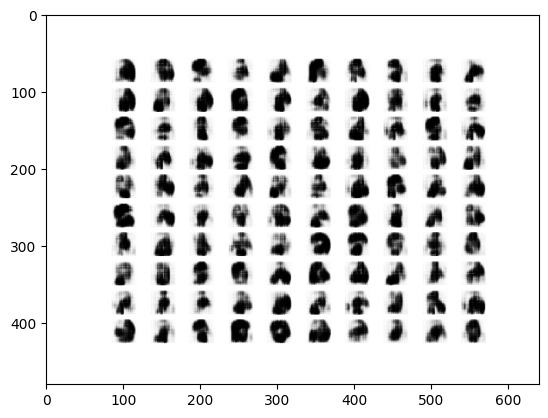

In [11]:
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

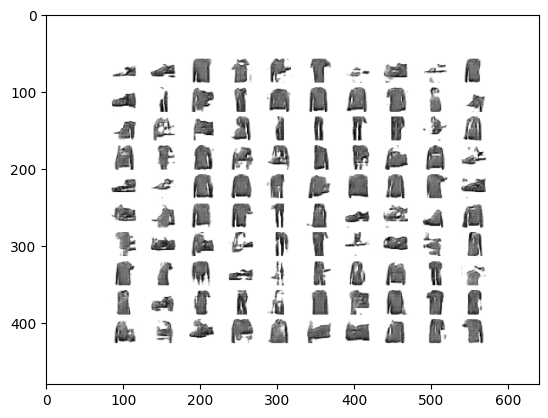

In [12]:
plt.imshow(plt.imread('generated_plot_e010.png'))
plt.show()

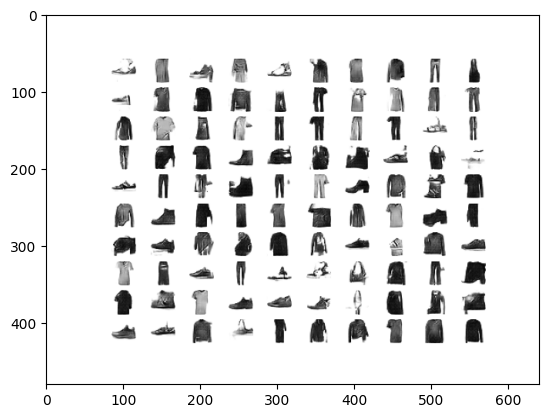

In [13]:
plt.imshow(plt.imread('generated_plot_e100.png'))
plt.show()

Nada mal, ¿verdad? Pero... ¿y si quisiéramos generar solo zapatos? ¿O solo camisetas?

Para ello, necesitamos transformar esta GAN en una GAN condicional o CGAN.

Podéis guiaros con este ejemplo: https://keras.io/examples/generative/conditional_gan/.